# Data From the Web

#### Requirements

to run this notebook you need:
`pandas==0.20.3`
`requests==2.18.4`
`urllib3==1.22`
`seaborn==0.8`
and access to the internet

## Scraping `www.topuniversities.com`

### Goal
Get information about number of students, ranking position from topuniversities website

#### Improvements
- Use regular expression inside function `get_data_url`
- Improve regular expression in the functions `parse_...` because it is getting wrong information in some case since we are using `re.findall('\d+')` to match numeric results. 

In [1]:
import json
import re
import requests
import pandas as pd
from urllib import parse as urlparse
from functools import reduce 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import logging
import numpy as np
import seaborn as sns
%matplotlib inline

from IPython.display import HTML

In [2]:
TOPUNI_URL = 'https://www.topuniversities.com'
YEAR = '2018'
N_TOP = 200

### Get general information and `url` of each university

In this part of the code we'll get the general information about the universities such as ranking, name, and url.

The `url` is the most important because it is based on the `url` that all others informations as number of students, number of staffs, etc will be extracted

In [3]:
def get_data_url(url):
    '''returns the url that contains a list of all universities'''
    
    LINK_TEXT_TO_FILTER = 'QS World University Rankings {year}'.format(year=YEAR)
    KEY_FILTER_RANK_URL = 'rank_url'
    
    r_main = requests.get(url)
    soup_main = BeautifulSoup(r_main.text, 'html.parser')
    links_in_main = soup_main.find_all('a')

    relative_link = list(filter(lambda x: x.text==LINK_TEXT_TO_FILTER, links_in_main))[0].get('href')
    urltops = urlparse.urljoin(TOPUNI_URL, relative_link)

    r_tops = requests.get(urltops)
    soup_tops = BeautifulSoup(r_tops.text, 'html.parser')
    
    # too dirty: use regular expression to do it!!
    text_tops_info = list(filter(lambda x: 'rank_url' in x.text, soup_tops.find_all('script')))[0].text
    position_link_info = text_tops_info.index(KEY_FILTER_RANK_URL)
    
    return text_tops_info[position_link_info + 11: position_link_info + 97].replace("\\", "")


def treat_uni_ranking(ranking_data):
    '''filter keys and treat information that comes from url found in `get_data_url`'''
    
    KEY_TO_FILTER = ['country', 'region', 'score', 'stars', 'title', 'url', 'rank_display']
    
    filtered = dict((key,value) for key, value in ranking_data.items() if key in KEY_TO_FILTER)
    filtered['url'] = urlparse.urljoin(TOPUNI_URL, filtered['url'])
    filtered['rank_display'] = int(filtered['rank_display'].replace('=', '').split('-')[0])
    
    return filtered

In [4]:
topuni_data_url = get_data_url(TOPUNI_URL)
topuni_data_text = requests.get(topuni_data_url).text

topuni_data_raw = json.loads(topuni_data_text)['data']
topuni_data = list(map(lambda d: treat_uni_ranking(d), topuni_data_raw))
topuni_data = list(filter(lambda d: d['rank_display']<N_TOP, topuni_data))

In [5]:
print('Number of universities with ranking until 200: {len_}'.format(len_=len(topuni_data)))
HTML(pd.DataFrame(topuni_data).head().to_html())

Number of universities with ranking until 200: 198


,country,rank_display,region,score,stars,title,url
0,United States,1,North America,100,6,Massachusetts Institute of Technology (MIT),https://www.topuniversities.com/universities/m...
1,United States,2,North America,98.7,5,Stanford University,https://www.topuniversities.com/universities/s...
2,United States,3,North America,98.4,5,Harvard University,https://www.topuniversities.com/universities/h...
3,United States,4,North America,97.7,5,California Institute of Technology (Caltech),https://www.topuniversities.com/universities/c...
4,United Kingdom,5,Europe,95.6,5,University of Cambridge,https://www.topuniversities.com/universities/u...


### Get all relevant information based in the `url`s found in the previous step

In this part the `url` information extracted in the previous step will be used.

The function `get_univ_info` will be applied for each `url` or university and it'll extract all the relevant information.

The functions `{parse_students, parse_international_students, parse_staffs, parse_ranking_employability, parse_past_rankings}` are called by the function `get_univ_info`.

In [6]:
def parse_students(soup):
    '''get and parse numbers of students'''
    try:
        raw_text = soup.find_all('div', class_='students-main wrapper col-md-4 item')[0].text
        treated_text = raw_text.replace('\n', '').replace('%', '').replace(',', '')
        numbers = list(map(lambda x: int(x), re.findall('\d+', treated_text)))
    except IndexError:
        numbers = [None, None]
    
    for i in range(3-len(numbers)):
        numbers.append(None)
    
    return {'#students': numbers[0], 
            '%students_posgraduate': numbers[1],
            '%students_undergraduate': numbers[2]}

def parse_international_students(soup):
    '''get and parse numbers of international students'''
    try:
        raw_text = soup.find_all('div', class_='int-students-main wrapper col-md-4')[0].text
        treated_text = raw_text.replace('\n', '').replace('%', '').replace(',', '')
        numbers = list(map(lambda x: int(x), re.findall('\d+', treated_text)))
    except IndexError:
        numbers = [None, None]
    
    for i in range(3-len(numbers)):
        numbers.append(None)
    
    return {'#international': numbers[0],
            '%international_postgraduate': numbers[1],
            '%international_undergraduate': numbers[2]}

def parse_staffs(soup):
    '''get and parse numbers of staffs'''
    try:
        raw_text = soup.find_all('div', class_='faculty-main wrapper col-md-4 item active')[0].text
        treated_text = raw_text.replace('\n', '').replace('%', '').replace(',', '')
        numbers = list(map(lambda x: int(x), re.findall('\d+', treated_text)))
    except IndexError:
        numbers = [None, None]
    
    for i in range(2-len(numbers)):
        numbers.append(None)
    
    return {'#staffs': numbers[0], 
            '#staffs_international': numbers[1]}

def parse_ranking_employability(soup): 
    '''get and parse employability ranking'''
    try:
        raw_text = soup.find_all('div', class_='faculty-main wrapper col-md-4 item active')[0].text
        treated_text = raw_text.replace('\n', '').replace('%', '').replace('\n', '')
    except IndexError:
        return {'ranking_employability': None}
    
    return {'ranking_employability': int(re.findall('\d+', treated_text)[0])}


def parse_past_rankings(soup):
    '''get and parse pasts rankings'''
    
    consult_year_minus1 = (soup
                           .find_all('div', 
                                     class_='views-row views-row-2 views-row-even y{year}'
                                     .format(year=int(YEAR)-1)))
    consult_year_minus2 = (soup
                           .find_all('div', 
                                     class_='views-row views-row-1 views-row-odd views-row-first y{year}'
                                     .format(year=int(YEAR)-2)))
    
    year_minus1_raw = consult_year_minus1[0].text if len(consult_year_minus1)==1 else None
    year_minus2_raw = consult_year_minus2[0].text if len(consult_year_minus1)==1 else None
    
    ranking_minus1 = int(re.findall('\d+', year_minus1_raw.replace('\n', ''))[0]) if year_minus1_raw else None
    ranking_minus2 = int(re.findall('\d+', year_minus2_raw.replace('\n', ''))[0]) if year_minus2_raw else None
    
    return {'ranking_{year}'.format(year=int(YEAR)-1): ranking_minus1,
            'ranking_{year}'.format(year=int(YEAR)-2): ranking_minus2}


def get_univ_info(uni_url):
    '''get information of each university and apply functions to parse and extract information'''
    r_university = requests.get(uni_url)
    soup_university = BeautifulSoup(r_university.text, 'html.parser')
    fns_to_apply = [parse_students, 
                    parse_international_students,
                    parse_staffs, 
                    parse_ranking_employability,
                    parse_past_rankings]
    
    informations = list(map(lambda fn: fn(soup_university), fns_to_apply))
    informations = reduce(lambda a, b: dict(a, **b), informations)

    if set(informations.values())==set([None]):
        logging.warning('Unable to find information for {url}'.format(url=uni_url))
                                
    return informations

In [7]:
topuni_urls = list(map(lambda d: d['url'], topuni_data))
topuni_remained_informations = list(map(lambda url: get_univ_info(url), topuni_urls))

In [8]:
topuni_all = list(map(lambda x: dict(x[0], **x[1]), zip(topuni_data, topuni_remained_informations)))

Example of one university

In [9]:
HTML(pd.DataFrame(pd.DataFrame(topuni_all).T[0]).to_html())

,0
#international,3717
#staffs,2982
#staffs_international,1679
#students,11067
%international_postgraduate,83
%international_undergraduate,17
%students_posgraduate,60
%students_undergraduate,40
country,United States
rank_display,1


### Data Analysis (TopUniversities)

- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

In [10]:
df_topuni = pd.DataFrame(topuni_all)

In [11]:
df_topuni.head(n=23)

,#international,#staffs,#staffs_international,#students,%international_postgraduate,%international_undergraduate,%students_posgraduate,%students_undergraduate,country,rank_display,ranking_2016,ranking_2017,ranking_employability,region,score,stars,title,url
0,3717.0,2982.0,1679.0,11067.0,83.0,17.0,60.0,40.0,United States,1,1.0,1.0,2.0,North America,100,6,Massachusetts Institute of Technology (MIT),https://www.topuniversities.com/universities/m...
1,3611.0,4285.0,2042.0,15878.0,83.0,17.0,56.0,44.0,United States,2,3.0,2.0,4.0,North America,98.7,5,Stanford University,https://www.topuniversities.com/universities/s...
2,5266.0,4350.0,1311.0,22429.0,85.0,15.0,69.0,31.0,United States,3,2.0,3.0,4.0,North America,98.4,5,Harvard University,https://www.topuniversities.com/universities/h...
3,647.0,953.0,350.0,2255.0,87.0,13.0,56.0,44.0,United States,4,5.0,5.0,953.0,North America,97.7,5,California Institute of Technology (Caltech),https://www.topuniversities.com/universities/c...
4,6699.0,5490.0,2278.0,18770.0,64.0,36.0,37.0,63.0,United Kingdom,5,3.0,4.0,5.0,Europe,95.6,5,University of Cambridge,https://www.topuniversities.com/universities/u...
5,7353.0,6750.0,2964.0,19720.0,74.0,26.0,44.0,56.0,United Kingdom,6,6.0,6.0,6.0,Europe,95.3,5,University of Oxford,https://www.topuniversities.com/universities/u...
6,14854.0,6345.0,2554.0,31080.0,55.0,45.0,48.0,52.0,United Kingdom,7,7.0,7.0,6.0,Europe,94.6,None,UCL (University College London),https://www.topuniversities.com/universities/u...
7,8746.0,3930.0,2071.0,16090.0,53.0,47.0,43.0,57.0,United Kingdom,8,8.0,9.0,3.0,Europe,93.7,None,Imperial College London,https://www.topuniversities.com/universities/i...
8,3379.0,2449.0,635.0,13557.0,76.0,24.0,57.0,43.0,United States,9,10.0,10.0,2.0,North America,93.5,5,University of Chicago,https://www.topuniversities.com/universities/u...
9,7563.0,2477.0,1886.0,19815.0,72.0,28.0,53.0,47.0,Switzerland,10,9.0,8.0,2.0,Europe,93.3,None,ETH Zurich - Swiss Federal Institute of Techno...,https://www.topuniversities.com/universities/e...


##### Which are the best universities in terms of ratio between faculty members and students?
Where you have more staffs per student 

In [12]:
df_topuni['ratio_staffs_students'] = (df_topuni['#staffs'] / df_topuni['#students']).apply(lambda x: round(x, 3))
cols_to_filter = ['title', 'ratio_staffs_students', 'region', 'rank_display']
HTML(df_topuni.sort_values('ratio_staffs_students', ascending=False)[cols_to_filter].head().to_html())

,title,ratio_staffs_students,region,rank_display
3,California Institute of Technology (Caltech),0.423,North America,4
15,Yale University,0.398,North America,16
5,University of Oxford,0.342,Europe,6
4,University of Cambridge,0.292,Europe,5
16,Johns Hopkins University,0.276,North America,17


Based on the topuniversitities data, ** California Institute of Technology (Caltech) ** is the best university in terms of ratio between faculty members and students.

##### Which are the best universities in terms of ratio of international students?

In [13]:
df_topuni['ratio_international_students'] =  (df_topuni['#international'] / df_topuni['#students']).apply(lambda x: round(x, 3))
cols_to_filter = ['title', 'ratio_international_students', 'region', 'rank_display']
HTML(df_topuni.sort_values('ratio_international_students', ascending=False)[cols_to_filter].head().to_html())

,title,ratio_international_students,region,rank_display
34,London School of Economics and Political Scien...,0.691,Europe,35
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570,Europe,12
7,Imperial College London,0.544,Europe,8
47,Carnegie Mellon University,0.478,North America,47
6,UCL (University College London),0.478,Europe,7


Based on the topuniversitities data, ** London School of Economics and Political Sciences ** is the best university in terms of ratio of international students.

##### Which are the best universities in term of ratio between faculty members and students per country?

In [14]:
agg_topuni = df_topuni.sort_values(['country', 'ratio_staffs_students']).groupby('country')
df_topuni['ranking_staffs_students_by_country'] = (agg_topuni['ratio_staffs_students']
                                                   .rank(method='first', ascending=False))

In [15]:
cols_to_filter = ['country', 'title', 'rank_display', 'ratio_staffs_students']
(df_topuni[df_topuni['ranking_staffs_students_by_country']==1]
 .sort_values('ratio_staffs_students', ascending=False)
 [cols_to_filter])

,country,title,rank_display,ratio_staffs_students
3,United States,California Institute of Technology (Caltech),4,0.423
5,United Kingdom,University of Oxford,6,0.342
116,Denmark,Technical University of Denmark,116,0.238
94,Russia,Lomonosov Moscow State University,95,0.222
70,South Korea,Pohang University of Science And Technology (P...,71,0.213
58,France,Ecole Polytechnique,59,0.208
181,Belgium,Vrije Universiteit Brussel (VUB),182,0.193
73,Switzerland,University of Zurich,73,0.192
75,Japan,Tohoku University,76,0.191
123,Netherlands,Wageningen University,124,0.179


##### Which are the best universities in term of ratio of international students per region?

In [16]:
agg_topuni = df_topuni.sort_values(['region', 'ratio_international_students']).groupby('region')
df_topuni['ranking_students_international_by_region'] = (agg_topuni['ratio_international_students']
                                                   .rank(method='first', ascending=False))

In [17]:
cols_to_filter = ['region', 'title', 'rank_display', 'ratio_international_students']
(df_topuni[df_topuni['ranking_students_international_by_region']==1]
 .sort_values('ratio_international_students', ascending=False)
 [cols_to_filter])

,region,title,rank_display,ratio_international_students
34,Europe,London School of Economics and Political Scien...,35,0.691
47,North America,Carnegie Mellon University,47,0.478
41,Oceania,The University of Melbourne,41,0.427
25,Asia,The University of Hong Kong,26,0.407
74,Latin America,Universidad de Buenos Aires (UBA),75,0.222
190,Africa,University of Cape Town,191,0.170


In [18]:
(df_topuni[
    df_topuni['title']=='Ecole Polytechnique Fédérale de Lausanne (EPFL)']
 [['title', 'rank_display', 'ranking_students_international_by_region']])

,title,rank_display,ranking_students_international_by_region
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,2.0


## Scraping `www.timeshighereducation.com`

In this part of the code, we scrape data from timeshighereducation.com

### Observations
* Region data is not available on timeshigher
* Rest of the required data is available in the inital json itself and thus we did not need to scrape the details page of individual universities

In [19]:
# Make the request
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

In [20]:
data = r.json()['data']

In [21]:
#Define column names for timeshigher DF
cols = ["TH:Name", 
        "TH:Rank", 
        "TH:Country", 
        "TH:Region", 
        "TH:Faculty  - International",
        "TH:Faculty  - Total", 
        "TH:Student  - International", 
        "TH:Students  - Total", 
        "TH:Faculty-Student Ratio",
        "TH:International Student Ratio"]

Example of a particular university with corresponding metrics :

In [22]:
data[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Here, we are appending the data for the top 200 universities in a dictionary which we will further use to create the dataframe.

In [23]:
times_higher_rankings_raw = []
for i in range(200):
    univ_data = data[i]
    times_higher_rankings_raw.append(dict(zip(cols, [univ_data['name'],
                                                      univ_data['rank'],
                                                      univ_data['location'],
                                                      '',
                                                      '',
                                                      int(int(univ_data['stats_number_students'].replace(',', ''))/float(univ_data['stats_student_staff_ratio'])), 
                                                      int(float(univ_data['stats_pc_intl_students'][:-1])*int(univ_data['stats_number_students'].replace(',', ''))/100),
                                                      univ_data['stats_number_students'].replace(',', ''),
                                                      1.0/np.float(univ_data['stats_student_staff_ratio']),
                                                      np.float(univ_data['stats_pc_intl_students'][:-1])/100]))) 
    
#Applying tranformations on student faculty ratio and international student ratio to 
#make it consistent with top univiersities data

In [24]:
#Constructing the dataframe based on the addregated dictionary in the last step
timeshigherrankings = pd.DataFrame(times_higher_rankings_raw)

### Data Analysis (TimesHigher)

- Which are the best universities in terms of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

##### Which are the best universities in terms of ratio between faculty members and students?

In [25]:
timeshigherrankings.sort_values(by='TH:Faculty-Student Ratio', ascending=False).head(5)

,TH:Country,TH:Faculty - International,TH:Faculty - Total,TH:Faculty-Student Ratio,TH:International Student Ratio,TH:Name,TH:Rank,TH:Region,TH:Student - International,TH:Students - Total
105,United States,,3639,0.303030,0.13,Vanderbilt University,=105,,1561,12011
109,Denmark,,7413,0.243902,0.14,University of Copenhagen,=109,,4255,30395
153,United States,,2240,0.232558,0.29,University of Rochester,=153,,2794,9636
11,United States,,2826,0.232558,0.21,Yale University,12,,2552,12155
12,United States,,3604,0.232558,0.24,Johns Hopkins University,13,,3719,15498


Based on TimeHigher data, ** Vanderbilt University ** is the best university in terms of ratio between faculty members and students.

##### Which are the best universities in terms of ratio of international students?

In [26]:
timeshigherrankings.sort_values(by='TH:International Student Ratio', ascending=False).head(5)

,TH:Country,TH:Faculty - International,TH:Faculty - Total,TH:Faculty-Student Ratio,TH:International Student Ratio,TH:Name,TH:Rank,TH:Region,TH:Student - International,TH:Students - Total
24,United Kingdom,,825,0.081967,0.71,London School of Economics and Political Science,=25,,7146,10065
178,Luxembourg,,340,0.068493,0.57,University of Luxembourg,=179,,2832,4969
37,Switzerland,,886,0.089286,0.55,École Polytechnique Fédérale de Lausanne,=38,,5460,9928
7,United Kingdom,,1390,0.087719,0.55,Imperial College London,8,,8721,15857
102,Netherlands,,929,0.055556,0.50,Maastricht University,103,,8363,16727


Based on TimeHigher data, ** London School of Economics and Political Science ** is the best university in terms of ratio of international students.

##### Which are the best universities in terms of ratio between faculty members and students per country?

In [27]:
agg_timeshigher = timeshigherrankings.sort_values(['TH:Country', 'TH:Faculty-Student Ratio']).groupby('TH:Country')
timeshigherrankings['TH:ranking_staffs_students_by_country'] = (agg_timeshigher['TH:Faculty-Student Ratio']
                                                   .rank(method='first', ascending=False))

In [28]:
cols_to_filter = ['TH:Country', 'TH:Name', 'TH:Rank', 'TH:Faculty-Student Ratio']
(timeshigherrankings[timeshigherrankings['TH:ranking_staffs_students_by_country']==1]
 .sort_values('TH:Faculty-Student Ratio', ascending=False)
 [cols_to_filter])

,TH:Country,TH:Name,TH:Rank,TH:Faculty-Student Ratio
105,United States,Vanderbilt University,=105,0.303030
109,Denmark,University of Copenhagen,=109,0.243902
114,France,École Polytechnique,115,0.196078
183,Italy,Scuola Normale Superiore di Pisa,184,0.192308
135,Switzerland,University of Zurich,136,0.169492
45,Japan,University of Tokyo,46,0.149254
193,Russian Federation,Lomonosov Moscow State University,194,0.136986
131,China,University of Science and Technology of China,132,0.121951
198,Sweden,University of Gothenburg,=198,0.100000
136,South Korea,Pohang University of Science and Technology,=137,0.096154


##### Which are the best universities in terms of ratio of international students per country?

In [29]:
agg_timeshigher = timeshigherrankings.sort_values(['TH:Country', 'TH:International Student Ratio']).groupby('TH:Country')
timeshigherrankings['TH:ranking_students_international_by_country'] = (agg_timeshigher['TH:International Student Ratio']
                                                   .rank(method='first', ascending=False))

In [30]:
cols_to_filter = ['TH:Country', 'TH:Name', 'TH:Rank', 'TH:International Student Ratio']
(timeshigherrankings[timeshigherrankings['TH:ranking_students_international_by_country']==1]
 .sort_values('TH:International Student Ratio', ascending=False)
 [cols_to_filter])

,TH:Country,TH:Name,TH:Rank,TH:International Student Ratio
24,United Kingdom,London School of Economics and Political Science,=25,0.71
178,Luxembourg,University of Luxembourg,=179,0.57
37,Switzerland,École Polytechnique Fédérale de Lausanne,=38,0.55
102,Netherlands,Maastricht University,103,0.50
23,United States,Carnegie Mellon University,24,0.45
39,Hong Kong,University of Hong Kong,40,0.42
31,Australia,University of Melbourne,32,0.40
114,France,École Polytechnique,115,0.36
174,Belgium,Université Libre de Bruxelles,=175,0.35
51,Singapore,"Nanyang Technological University, Singapore",52,0.31


## Merging using University Names

For merging the data from the two different sources, we are following a heuristic which is summarized as follows :

* Remove common words (dict `common` below) from the names of universities.
* For given pair of universities `(a,b)`, we calculate the score as ratio of number of words in `b` which are present in `a` and the total number of words in `b`.
* For each university in TopUniv data, find a university in TimesHigher data such that the score is maximum.
* For pair of university names `(a,b)`, score of `0` indicates that all words are distinct and score of `1` indicates that all words in `b` are present in `a`

In [31]:
#Creating a list of most commonly occuring words in university names.
common = ['university', 'technology', 'institute', 'the', 'and', 'din', 'universität', 'université',
         'universidad', 'universidade', 'research', 'superiore']



def remove_common(sentence):
    
    #Converting University Names to lower case for general purpose, removing '-' sign, and splitting to get individual words
    sentence = sentence.lower()
    sentence = sentence.replace('-', ' ')
    sentence = sentence.replace('(', '')
    sentence = sentence.replace(')', '')
    sentence = sentence.replace(',', '')
    sentence = sentence.split()
    
    #Filtering the name based on the common word list mentioned above
    sentence = [x for x in sentence if x not in common and len(x)>2]
    
    #Joining the words again with spaces in between
    sentence = ' '.join(sentence)

    return sentence.strip()

#Creating an empty dictionary which will store the matching names of Universities
matching_dict = {}

for TU_uni_name in df_topuni[['title']].values:
    TU_clean_uni_name = remove_common(TU_uni_name[0])
    counts=[]
    TH_clean_uni_name_list = []
    matched_word_list =[]
    TH_uni_name_list = []
    
    for TH_uni_name in timeshigherrankings[['TH:Name']].values:
        TH_clean_uni_name = remove_common(TH_uni_name[0])
        TH_clean_uni_name_list.append(TH_clean_uni_name)
        TH_uni_name_list.append(TH_uni_name[0])
        
        TH_clean_uni_word_list = TH_clean_uni_name.split()
        count=0
        matched_word=[] #C
        for word in TH_clean_uni_word_list:
            if word in TU_clean_uni_name.split():
                count+=1
                matched_word.append(word)
        
        matched_word_list.append(matched_word)
        counts.append(count)
        
    ratio = max(counts)/len(TH_clean_uni_name_list[counts.index(max(counts))].split())
    matching_dict[TU_uni_name[0]] = {'Matching': TH_uni_name_list[counts.index(max(counts))], 'Score': ratio}            

`matching_dict` contains the final result of the above heuristic, where

key = university name from TopUniv

value is a dict with 'Matching' having the university from TimesHigher with the highest score and 'Score' having the corresponding score

In [32]:
matching_dict

{'Aalto University': {'Matching': 'Aalto University', 'Score': 1.0},
 'Aarhus University': {'Matching': 'Aarhus University', 'Score': 1.0},
 'Albert-Ludwigs-Universitaet Freiburg': {'Matching': 'University of Freiburg',
  'Score': 1.0},
 'Alma Mater Studiorum - University of Bologna': {'Matching': 'University of Oxford',
  'Score': 0.0},
 'Boston University': {'Matching': 'Boston University', 'Score': 1.0},
 'Brown University': {'Matching': 'Brown University', 'Score': 1.0},
 'California Institute of Technology (Caltech)': {'Matching': 'California Institute of Technology',
  'Score': 1.0},
 'Cardiff University': {'Matching': 'Cardiff University', 'Score': 1.0},
 'Carnegie Mellon University': {'Matching': 'Carnegie Mellon University',
  'Score': 1.0},
 'CentraleSupélec': {'Matching': 'University of Oxford', 'Score': 0.0},
 'Chalmers University of Technology': {'Matching': 'University of Oxford',
  'Score': 0.0},
 'City University of Hong Kong': {'Matching': 'City University of Hong Kong

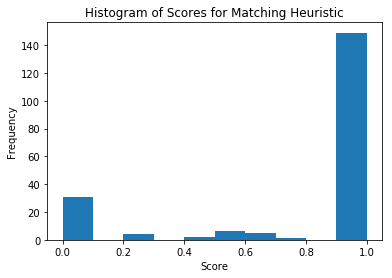

In [33]:
score_values = [matching_dict[x]['Score'] for x in matching_dict.keys()]
plt.hist(score_values)
plt.title("Histogram of Scores for Matching Heuristic")
plt.xlabel("Score")
plt.ylabel("Frequency")

### Observations

* About 150 university pairs have scores close to 1 and thus are matching well with each other.
* We will discard pairs which have scores less than a threshold (we use 0.7)

In [34]:
#Choosing only those pairs of matches where the match score is above a certain threshold
thresh = 0.7
thresholded_matching_dict = {x : matching_dict[x]['Matching'] for x in matching_dict if matching_dict[x]['Score'] > thresh}

In [35]:
len(thresholded_matching_dict)

150

In [36]:
#Filtering out only those pairs which have different names
#Merge strategy is to drop unmatched universities from TopUniv data and 
#rename the rest with their matching univ's name from TimesHigher
#This will allow us to merge based on the univ names from both the data frames.
filtered_thresh_match_dict = {x : thresholded_matching_dict[x] for x in thresholded_matching_dict if x != thresholded_matching_dict[x]}

In [37]:
filtered_thresh_match_dict

{'Albert-Ludwigs-Universitaet Freiburg': 'University of Freiburg',
 'California Institute of Technology (Caltech)': 'California Institute of Technology',
 'ETH Zurich - Swiss Federal Institute of Technology': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'Eberhard Karls Universität Tübingen': 'University of Tübingen',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne',
 'Humboldt-Universität zu Berlin': 'Humboldt University of Berlin',
 'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advanced Institute of Science and Technology (KAIST)',
 'KIT, Karlsruhe Institute of Technology': 'Karlsruhe Institute of Technology',
 'London School of Economics and Political Science (LSE)': 'London School of Economics and Political Science',
 'Massachusetts Institute of Technology (MIT)': 'Massachusetts Institute of Technology',
 'Nanyang Technological University, Singapore (NTU)': 'Nanyang Technological University, Singapor

In [38]:
df_topuni_renamed = df_topuni.replace({'title' : filtered_thresh_match_dict})

In [39]:
df_topuni_renamed.set_index('title', inplace = True)

In [40]:
timeshigher_indexed = timeshigherrankings.set_index('TH:Name')

In [41]:
timeshigher_indexed

,TH:Country,TH:Faculty - International,TH:Faculty - Total,TH:Faculty-Student Ratio,TH:International Student Ratio,TH:Rank,TH:Region,TH:Student - International,TH:Students - Total,TH:ranking_staffs_students_by_country,TH:ranking_students_international_by_country
TH:Name,,,,,,,,,,,
University of Oxford,United Kingdom,,1822,0.089286,0.38,1,,7755,20409,3.0,10.0
University of Cambridge,United Kingdom,,1687,0.091743,0.35,2,,6436,18389,2.0,18.0
California Institute of Technology,United States,,339,0.153846,0.27,=3,,596,2209,11.0,7.0
Stanford University,United States,,2112,0.133333,0.22,=3,,3485,15845,15.0,19.0
Massachusetts Institute of Technology,United States,,1284,0.114943,0.34,5,,3800,11177,21.0,2.0
Harvard University,United States,,2283,0.112360,0.26,6,,5284,20326,22.0,9.0
Princeton University,United States,,958,0.120482,0.24,7,,1909,7955,17.0,13.0
Imperial College London,United Kingdom,,1390,0.087719,0.55,8,,8721,15857,4.0,2.0
University of Chicago,United States,,2181,0.161290,0.25,9,,3381,13525,10.0,11.0


In [42]:
cols_to_keep = {'#international' : 'TU:Student - International', '#staffs' : 'TU:Faculty - Total',
 '#staffs_international' : 'TU:Faculty - International', '#students' : 'TU:Students - Total',
 'country' : 'TU:Country', 'rank_display' : 'TU:Rank', 'region' : 'TU:Region'}
df_topuni_renamed.rename(columns = cols_to_keep, inplace = True)
df_topuni_renamed = df_topuni_renamed[list(cols_to_keep.values())]

In [43]:
merged_data = df_topuni_renamed.merge(timeshigher_indexed, left_index = True, right_index = True)

In [44]:
merged_data

,TU:Student - International,TU:Faculty - Total,TU:Faculty - International,TU:Students - Total,TU:Country,TU:Rank,TU:Region,TH:Country,TH:Faculty - International,TH:Faculty - Total,TH:Faculty-Student Ratio,TH:International Student Ratio,TH:Rank,TH:Region,TH:Student - International,TH:Students - Total,TH:ranking_staffs_students_by_country,TH:ranking_students_international_by_country
Aalto University,1831.0,1257.0,370.0,12147.0,Finland,137,Europe,Finland,,630,0.049505,0.20,190,,2548,12744,2.0,1.0
Aarhus University,3762.0,2316.0,602.0,26226.0,Denmark,119,Europe,Denmark,,1759,0.069930,0.12,=109,,3020,25167,3.0,3.0
Australian National University,5551.0,1600.0,927.0,14442.0,Australia,20,Oceania,Australia,,828,0.051813,0.35,48,,5595,15986,1.0,2.0
Boston University,7041.0,3157.0,379.0,25662.0,United States,81,North America,United States,,2887,0.116279,0.25,=70,,6208,24833,19.0,12.0
Brown University,1825.0,1303.0,379.0,9251.0,United States,53,North America,United States,,831,0.093458,0.20,=50,,1779,8898,31.0,24.0
California Institute of Technology,647.0,953.0,350.0,2255.0,United States,4,North America,United States,,339,0.153846,0.27,=3,,596,2209,11.0,7.0
Cardiff University,6090.0,2755.0,705.0,24565.0,United Kingdom,137,Europe,United Kingdom,,1791,0.074074,0.26,=162,,6288,24186,14.0,30.0
Carnegie Mellon University,6385.0,1342.0,425.0,13356.0,United States,47,North America,United States,,938,0.074074,0.45,24,,5704,12676,42.0,1.0
Chinese University of Hong Kong,4824.0,2208.0,1074.0,18037.0,Hong Kong,46,Asia,Hong Kong,,1044,0.057803,0.31,58,,5602,18072,2.0,4.0
City University of Hong Kong,3273.0,1349.0,1027.0,9240.0,Hong Kong,49,Asia,Hong Kong,,825,0.089286,0.35,=119,,3234,9240,1.0,2.0


## Insights

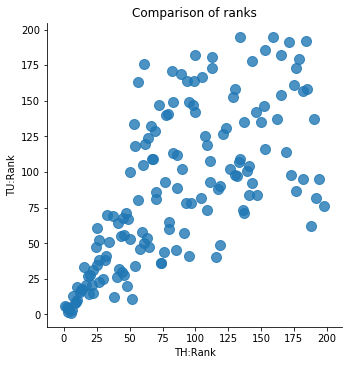

In [45]:
merged_data['TH:Rank'] = merged_data['TH:Rank'].str.replace('=', '')
merged_data['TH:Rank'] = merged_data['TH:Rank'].astype(int)

g = sns.lmplot('TH:Rank', # Horizontal axis
           'TU:Rank', # Vertical axis
           data=merged_data, # Data source
           fit_reg=False,  # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size
g = plt.title('Comparison of ranks')

#### Differences in Ranking by TopUniv and TimesHigher

* Top universities (rank < 25) are ranked similarly by both websites. This is indicated by the linear fit in of the data in lower range (close to origin).
* But when it comes to higher ranked universities, we find that the data points have a high variance along the `y = x` line. This indicates a significant deviation in the ranking stategy adopted by both websites.

In [46]:
TH_collective = merged_data[['TH:Country', 'TH:Rank']].groupby('TH:Country').agg(['count'])

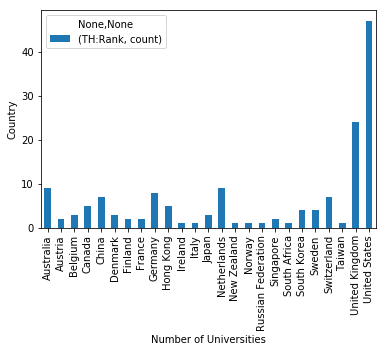

In [47]:
TH_collective.plot(kind='bar')
plt.ylabel('Country')
plt.xlabel('Number of Universities')

#### Distribution by region of top 200 universities

* We observe that US and UK alone have about 75 universities among the top 200. This could be indicative of either their focus on education in terms of policies, investment, awareness, etc. or biasedness of the ranking agencies.

In [48]:
new_cols_to_keep = ['TU:Student - International', 'TU:Faculty - Total', 'TU:Faculty - International',
                    'TU:Students - Total', 'TH:Faculty  - Total', 'TH:Student  - International',
                    'TH:Students  - Total']
merged_insight = merged_data[new_cols_to_keep]
merged_insight['TH:Students  - Total'] = merged_insight['TH:Students  - Total'].astype(int)

/Users/atul/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


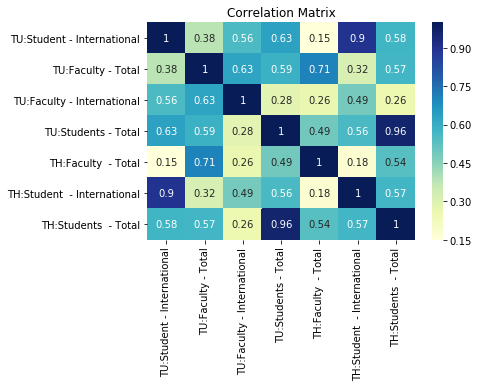

In [49]:
corr = merged_insight.corr()
cmap = sns.color_palette('BrBG')
sns.heatmap(corr, cmap="YlGnBu", annot = True)
plt.title('Correlation Matrix')

### Observations

* `TU:Student - International` is **highly correlated** to `TH:Student - International` (as it should). Similarly for other columns, an entity is highly correlated to itself and also to the corresponding entity of other website.
* In general, `Faculty - Total` data collected from both websites is **less correlated** to `Student - International` collected from both websites. However, `Faculty - International` is **moderately correlated** to `Students - International`, which makes sense, as it represents the outreach and appeal of the university internationally.
* We don't find **negative correlation** anywhere, which is logical because increase in the number of `Faculty` or `Student` shouldn't decrease the other.

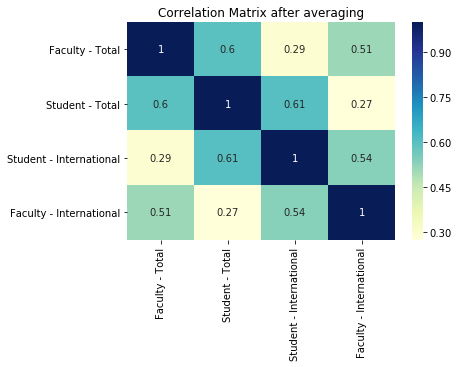

In [50]:
merge_average = pd.DataFrame()
merge_average['Faculty - Total'] = (merged_insight['TH:Faculty  - Total'] + merged_insight['TU:Faculty - Total']) / 2
merge_average['Student - Total'] = (merged_insight['TH:Students  - Total'] + merged_insight['TU:Students - Total']) / 2
merge_average['Student - International'] = (merged_insight['TH:Student  - International'] + merged_insight['TU:Student - International']) / 2
merge_average['Faculty - International'] = merged_insight['TU:Faculty - International']
corr = merge_average.corr()
cmap = sns.color_palette('BrBG')
g = sns.heatmap(corr, cmap="YlGnBu", annot = True)
g = plt.title('Correlation Matrix after averaging')

* Since similar entities from different websites were highly correlated (as seen in previous cell), we decided to take averages.
* The most striking observation from this matrix is that `Student - International` and `Faculty - Total` have very less correlation. Similarly, `Faculty - International` and `Student - Total` have very less corelation.
* Let's try taking ratio of the pairs and see further results.

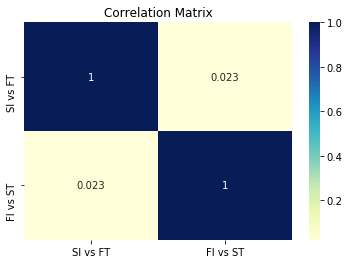

In [51]:
merge_average_new = pd.DataFrame()
merge_average_new['SI vs FT'] = merge_average['Student - International'] / merge_average['Faculty - Total']
merge_average_new['FI vs ST'] = merge_average['Faculty - International'] / merge_average['Student - Total']
corr = merge_average_new.corr()
cmap = sns.color_palette('BrBG')
g = plt.title('Correlation Matrix')
g = sns.heatmap(corr, cmap="YlGnBu", annot = True)

## Ranking

* The above correlation heatmap clearly shows the extremely less correlation between the two ratios. Hence, we would be choosing normailsed weighted sum of the two ratios to calculate our new rank.

### Strategy 1

In [52]:
merge_average_norm = (merge_average_new - merge_average_new.mean()) / (merge_average_new.max() - merge_average_new.min())
merge_average_norm['Score'] = (merge_average_norm['SI vs FT'] + merge_average_norm['FI vs ST']) / 2
merge_average_norm.sort_values('Score', ascending=False, inplace = True)
rank = pd.Series(np.array([x for x in range(1,154)]), index = merge_average_norm.index)
merge_average_norm['RankStrategy1'] = rank
merge_average_norm

,SI vs FT,FI vs ST,Score,RankStrategy1
London School of Economics and Political Science,0.666103,0.184746,0.425425,1
École Polytechnique Fédérale de Lausanne,0.261482,0.565351,0.413417,2
Imperial College London,0.103684,0.574326,0.339005,3
University of Hong Kong,0.198455,0.435142,0.316799,4
Monash University,0.676195,-0.054791,0.310702,5
University of Melbourne,0.646790,-0.036455,0.305167,6
Massachusetts Institute of Technology,-0.111296,0.711898,0.300301,7
University of Oxford,-0.111238,0.690991,0.289876,8
ETH Zurich – Swiss Federal Institute of Technology Zurich,0.193614,0.360942,0.277278,9
University of New South Wales,0.531515,-0.002243,0.264636,10


In [53]:
df_rank_corr_merge=pd.merge(merge_average_norm, merged_data[['TH:Rank', 'TU:Rank']], left_index=True, right_index=True)
df_rank_corr_merge.sort_values(by='RankStrategy1').head(25)

,SI vs FT,FI vs ST,Score,RankStrategy1,TH:Rank,TU:Rank
London School of Economics and Political Science,0.666103,0.184746,0.425425,1,25,35
École Polytechnique Fédérale de Lausanne,0.261482,0.565351,0.413417,2,38,12
Imperial College London,0.103684,0.574326,0.339005,3,8,8
University of Hong Kong,0.198455,0.435142,0.316799,4,40,26
Monash University,0.676195,-0.054791,0.310702,5,80,60
University of Melbourne,0.646790,-0.036455,0.305167,6,32,41
Massachusetts Institute of Technology,-0.111296,0.711898,0.300301,7,5,1
University of Oxford,-0.111238,0.690991,0.289876,8,1,6
ETH Zurich – Swiss Federal Institute of Technology Zurich,0.193614,0.360942,0.277278,9,10,10
University of New South Wales,0.531515,-0.002243,0.264636,10,85,45


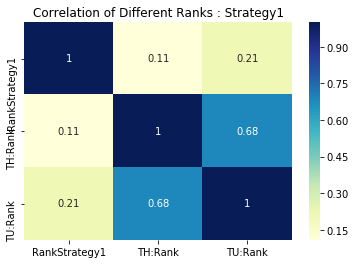

In [54]:
corr = df_rank_corr_merge[['RankStrategy1', 'TH:Rank', 'TU:Rank']].corr()
cmap = sns.color_palette('BrBG')
g = plt.title('Correlation of Different Ranks : Strategy1')
g = sns.heatmap(corr, cmap="YlGnBu", annot = True)

### Strategy 2

For this strategy, we take average of the ranks from websites as our score.

In [55]:
merge_rank_strategy2 = pd.DataFrame()
merge_rank_strategy2['RankAverage']  = (merged_data['TH:Rank'] + merged_data['TU:Rank'])/2
merge_rank_strategy2.sort_values('RankAverage', ascending=True, inplace = True)
rank = pd.Series(np.array([x for x in range(1,154)]), index = merge_rank_strategy2.index)
merge_rank_strategy2['RankStrategy2'] = rank

In [56]:
merge_rank_strategy2=pd.merge(merge_rank_strategy2, merged_data[['TH:Rank', 'TU:Rank']], left_index=True, right_index=True)
merge_rank_strategy2.sort_values(by='RankStrategy2').head(25)

,RankAverage,RankStrategy2,TH:Rank,TU:Rank
Stanford University,2.5,1,3,2
Massachusetts Institute of Technology,3.0,2,5,1
University of Oxford,3.5,3,1,6
California Institute of Technology,3.5,4,3,4
University of Cambridge,3.5,5,2,5
Harvard University,4.5,6,6,3
Imperial College London,8.0,7,8,8
University of Chicago,9.0,8,9,9
Princeton University,10.0,9,7,13
ETH Zurich – Swiss Federal Institute of Technology Zurich,10.0,10,10,10


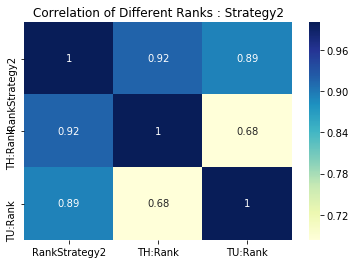

In [57]:
corr = merge_rank_strategy2[['RankStrategy2', 'TH:Rank', 'TU:Rank']].corr()
cmap = sns.color_palette('BrBG')
g = plt.title('Correlation of Different Ranks : Strategy2')
g = sns.heatmap(corr, cmap="YlGnBu", annot = True)